This block verifies that NumPy, Matplotlib, and SciPy are properly installed and importable. It ensures your scientific Python stack isn’t partially broken or mismatched (which can silently corrupt experiments). Version printing is especially important because NumPy 2.x introduced ABI and behavior changes that can break downstream libraries. If these imports fail, your environment is structurally unstable before you even begin spectral transport work.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy

print("NumPy:", np.__version__)
print("Matplotlib:", matplotlib.__version__)
print("SciPy:", scipy.__version__)

NumPy: 2.0.1
Matplotlib: 3.10.8
SciPy: 1.16.0


Creating one million float64 values and computing mean and variance validates high-precision numerical stability at scale. This ensures your floating-point pipeline behaves predictably under large array operations. Since spectral transport accumulates small contributions across many bounces, float64 correctness is critical. If variance or mean behave strangely, it indicates possible dtype fallback or corrupted BLAS behavior.

In [8]:
x = np.linspace(400.0, 700.0, 1_000_000, dtype=np.float64)

print("dtype:", x.dtype)
print("Mean:", np.mean(x))
print("Variance:", np.var(x))


dtype: float64
Mean: 550.0000000000001
Variance: 7500.015000015


Computing eigenvalues of a random matrix forces NumPy to invoke its LAPACK/BLAS backend. This test confirms your linear algebra stack (MKL, OpenBLAS, etc.) is correctly linked and functioning. Many advanced spectral methods or reconstruction techniques depend on stable eigendecomposition and matrix operations — if this fails, your backend is misconfigured.

In [4]:
A = np.random.rand(5,5)
eigvals = np.linalg.eigvals(A)

print("Eigenvalues:", eigvals)


Eigenvalues: [ 2.7221135 +0.j         -0.33390656+0.38554912j -0.33390656-0.38554912j
 -0.45539388+0.j          0.19437424+0.j        ]


Adding 1e-10 ten million times checks how floating-point accumulation behaves under extreme iteration. This mimics path tracing accumulation where tiny energy contributions add up over many bounces. If the result deviates significantly from ~0.001, your environment has precision drift or catastrophic cancellation issues.

In [5]:
acc = 0.0
for i in range(10_000_000):
    acc += 1e-10

print("Accumulated:", acc)


Accumulated: 0.0010000000001300626


Plotting a simple sine wave confirms the Matplotlib backend (TkAgg, Qt, etc.) is functional. This is important because your spectral debugging and ringing analysis depend heavily on visualization. A broken backend leads to silent failure in analysis workflows.

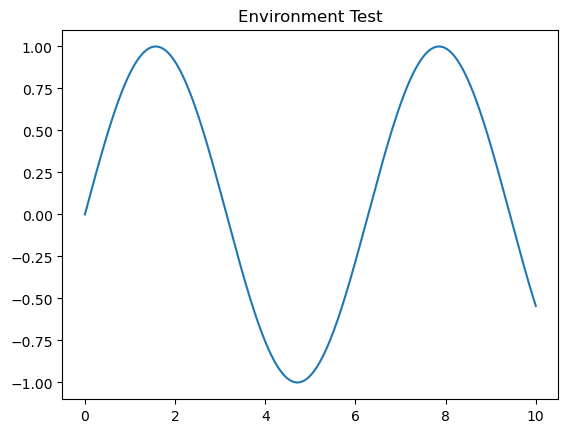

In [9]:
x = np.linspace(0, 10, 1000)
plt.plot(x, np.sin(x))
plt.title("Environment Test")
plt.show()


Printing Torch version, CUDA availability, device count, and default dtype verifies the ML backend is installed correctly and hardware acceleration (if any) is visible. This matters for future neural spectral reconstruction (FSNR) or Iota prototyping. Default dtype tells you whether you’re operating in float32 or float64 by default — critical for deterministic physics experiments.

In [10]:
import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Default dtype:", torch.get_default_dtype())


Torch version: 2.5.1
CUDA available: True
Device count: 1
Default dtype: torch.float32


Summing ten million float64 elements validates Torch’s reduction stability and memory allocator behavior. This mirrors high-sample Monte Carlo accumulation. If this produces incorrect output or crashes, your Torch build may lack proper float64 support or optimized backend kernels.

In [11]:
x = torch.full((10_000_000,), 1e-10, dtype=torch.float64)
print("Sum:", x.sum())


Sum: tensor(0.0010, dtype=torch.float64)


Performing a large 1024×1024 matrix multiplication checks Torch’s BLAS backend and threading. This confirms high-performance compute paths are working. Since spectral neural reconstruction or learned transport operators depend on stable dense linear algebra, this test verifies that heavy compute won’t silently degrade.

In [12]:
A = torch.randn(1024, 1024, dtype=torch.float64)
B = torch.randn(1024, 1024, dtype=torch.float64)

C = A @ B
print("Matrix multiply OK. Mean:", C.mean())


Matrix multiply OK. Mean: tensor(-0.0071, dtype=torch.float64)


Resetting the random seed twice and generating tensors verifies deterministic behavior on CPU. This is crucial for reproducibility — especially if you care about bit-exact reproducible pipelines (which you do). If this fails, your experiment results cannot be trusted across runs.

In [13]:
torch.manual_seed(42)

a = torch.randn(5)
torch.manual_seed(42)
b = torch.randn(5)

print("Deterministic:", torch.allclose(a, b))


Deterministic: True


Creating a scalar tensor with gradients and backpropagating verifies that Torch’s automatic differentiation engine works correctly. Even if BsSPT doesn’t use gradients now, neural components (FSNR or Iota) will. If autograd fails, your ML stack is incomplete.

In [14]:
x = torch.tensor(2.0, requires_grad=True)
y = x * x
y.backward()

print("Gradient:", x.grad)


Gradient: tensor(4.)


Checking the number of CPU threads tells you how Torch parallelizes operations. Too many threads can cause nondeterministic timing and performance instability. For deterministic HPC-style research, thread control is important.

In [15]:
print("Threads:", torch.get_num_threads())


Threads: 10


Running matrix multiplication on the GPU confirms CUDA kernels are functional and memory transfer is working. This ensures your GPU pipeline is valid for future acceleration. If CUDA is detected but this fails, your driver/runtime stack is inconsistent.

In [16]:
if torch.cuda.is_available():
    x = torch.randn(1024, 1024, device="cuda")
    y = torch.randn(1024, 1024, device="cuda")
    z = x @ y
    print("CUDA matmul mean:", z.mean().item())


CUDA matmul mean: -0.01099475659430027


Seeding CUDA and enabling deterministic algorithms checks whether GPU randomness behaves reproducibly. Full determinism on GPU is harder than CPU, so this test ensures you can control stochastic components — critical for neural training reproducibility.

In [17]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.use_deterministic_algorithms(True)

    a = torch.randn(5, device="cuda")
    torch.cuda.manual_seed(42)
    b = torch.randn(5, device="cuda")

    print("CUDA deterministic:", torch.allclose(a, b))


CUDA deterministic: True


Allocating ten million float64 values validates Torch’s memory allocator and checks for fragmentation or immediate OOM errors. If this fails on a machine with sufficient RAM, your environment is unstable.

In [18]:
x = torch.randn(10_000_000, dtype=torch.float64)
print("Memory OK:", x.shape)


Memory OK: torch.Size([10000000])


Printing torch.__config__.show() reveals backend details: MKL, OpenMP, AVX support, CUDA version, etc. This is your low-level diagnostic to understand exactly what hardware acceleration paths are enabled — extremely useful for performance debugging.

In [19]:
print(torch.__config__.show())


PyTorch built with:
  - C++ Version: 201703
  - MSVC 192930154
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.5.3 (Git Hash 66f0cb9eb66affd2da3bf5f8d897376f04aae6af)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86;-gencode;arch=compute_90,code=sm_90
  - CuDNN 90.1  (built against CUDA 12.4)
  - Magma 2.5.4
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=12.1, CUDNN_VERSION=9.1.0, CXX_COMPILER=C:/cb/pytorch_1000000000000/work/tmp_bin/sccache-cl.exe, CXX_FLAGS=/DWIN32 /D_WINDOWS /GR /EHsc /Zc:__cplusplus /bigobj /FS /utf-8 -DUSE_

Converting a NumPy array to a Torch tensor using from_numpy checks zero-copy memory sharing. This ensures seamless data exchange between scientific Python and Torch without unnecessary copying — important for hybrid pipelines (e.g., spectral simulation in NumPy → neural model in Torch).

In [20]:
import numpy as np

a = np.random.rand(5)
t = torch.from_numpy(a)

print("Interop OK:", t)


Interop OK: tensor([0.9072, 0.0313, 0.3079, 0.7034, 0.6945], dtype=torch.float64)
